In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [60]:
g2 = tf.Graph()
with g2.as_default():
    w1 = tf.Variable(1, name='w1')
    init_op=tf.global_variables_initializer()
    w2 = tf.Variable(2, name='w2')
    print(w1)
    
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print('w1: ', sess.run(w1))

<tf.Variable 'w1:0' shape=() dtype=int32_ref>
w1:  1


In [50]:
g = tf.Graph()

with g.as_default():
    tf.set_random_seed(123)
    tf_x = tf.placeholder(shape=(None),
                          dtype=tf.float32,
                          name='tf_x')
    tf_y = tf.placeholder(shape=(None),
                          dtype=tf.float32,
                          name='tf_y')
    weight = tf.Variable(tf.random_normal(shape=(1,1),stddev=0.25), name='weight')
    bias = tf.Variable(0.0, name='bias')
    
    y_hat = tf.add(weight * tf_x, bias, name='y_hat')
    
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost')
    
    optim = tf.train.GradientDescentOptimizer(
            learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')

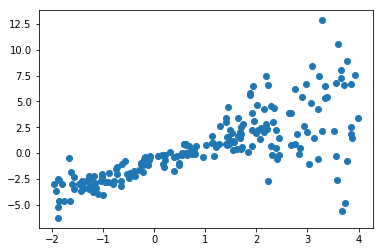

In [51]:
np.random.seed(0)

def make_random_data():
    x = np.random.uniform(low=-2, high=4, size=200)
    y = []
    for t in x:
        r = np.random.normal(loc=0.0, scale=(0.5 + t*t/3), size=None)
        y.append(r)
    return x, 1.726*x -0.84 + np.array(y)

x, y = make_random_data()
plt.plot(x,y,'o')
plt.show()

Epoch    0:  12.2230
Epoch   50:   8.3876
Epoch  100:   6.5721
Epoch  150:   5.6844
Epoch  200:   5.2269
Epoch  250:   4.9725
Epoch  300:   4.8169
Epoch  350:   4.7119
Epoch  400:   4.6347
Epoch  450:   4.5742


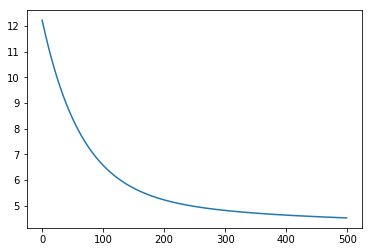

In [54]:
X_train, y_train = x[:100], y[:100]
X_test, y_test = x[100:], y[100:]

n_epochs = 500
training_costs = []

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        c,_ = sess.run([cost, train_op], feed_dict={tf_x:X_train, tf_y:y_train})
        training_costs.append(c)
        if not e % 50:
            print('Epoch %4d: %8.4f' % (e, c))
            
plt.plot(training_costs)
plt.show()

In [62]:
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf.get_variable(name = 'weights',
                              shape=(data_shape[1],
                                     n_classes),
                              dtype=tf.float32)
    bias = tf.get_variable(name='bias', 
                           initializer=tf.zeros(
                                     shape=n_classes))
    print(weights)
    print(bias)
    logits = tf.add(tf.matmul(data, weights), 
                    bias, 
                    name='logits')
    print(logits)
    return logits, tf.nn.softmax(logits)


def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    w1 = tf.Variable(
        tf.random_normal(shape=(data_shape[1], 
                                n_hidden)),
        name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden),
                     name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1, 
                    name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
        
    w2 = tf.Variable(
        tf.random_normal(shape=(n_hidden, 
                                data_shape[1])),
        name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]),
                     name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2, 
                    name = 'output')
    return output, tf.nn.sigmoid(output)


###########################
##  Building the graph   ##
###########################

batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), 
                          dtype=tf.float32,
                          name='tf_X')
    
    ## build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, 
                                   n_hidden=50)
    
    ## build the classifier
    with tf.variable_scope('classifier') as scope:
        ## classifier for the original data:
        cls_out1 = build_classifier(data=tf_X, 
                                    labels=tf.ones(
                                        shape=batch_size))
        
        ## reuse the classifier for generated data
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1],
                                    labels=tf.zeros(
                                        shape=batch_size))
        
with tf.Session(graph = g) as sess:
    sess.run(tf.global_variables_initializer())
    
    file_writer = tf.summary.FileWriter(logdir='logs/', graph=g)

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)
